## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Packages that set dynamic parameters are imported from the recipes directory. Their names specify their corresponding nonadiabatic dynamics methods. Specifically, nonadiabatic dynamics methods based on exact factorization (XF) contain 'xf' in their names. Try to run other methods for comparison.

    from recipes import shxf, mqcxf, ehxf
    from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
    from recipes import fssh, sdm, bcsh

# Nonadiabatic dynamics based on exact factorization in Libra


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF](#2.1)

3. [Model Hamiltonians](#3)

4. [Choosing the Nonadiabatic Dynamics Methodology](#4)

5. [Choosing initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)

8. [Comparison with quantum dynamics](#8)


In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Tully as Tully
import libra_py.models.Subotnik as Subotnik
import libra_py.models.Esch_Levine as Esch_Levine
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import shxf, mqcxf, ehxf
from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
from recipes import fssh, sdm, bcsh

import libra_py.dynamics.exact.compute as dvr
import libra_py.dynamics.exact.save as dvr_save

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

XF is a wave function ansatz in which the total wave function is separated into a nuclear wave function and its conditional electronic wave function, represented as:

$$\Psi(\mathbf{r},\mathbf{R},t)=\chi(\mathbf{R},t)\Phi_{\mathbf{R}}(\mathbf{r},t)$$

Based on XF, the mixed quantum-classical (MQC) equations have been formulated for trajectory-based nonadiabatic dynamics:  
$$ i\hbar \frac{d}{dt}\Phi_{\mathbf{R}}(\mathbf{r},t)= \left[ H_{BO}(\mathbf{r};\mathbf{R})+\sum_{\nu}\frac{-i\mathcal{P}_{\nu}}{M_{\nu}}\cdot (\mathbf{A}_{\nu}+i\hbar \nabla_{\nu}) \right]\Phi_{\mathbf{R}}(\mathbf{r},t) $$

$$ \mathbf{F}_{\nu}=-\langle \Phi_{\mathbf{R}}|\nabla_{\nu}\hat{H}_{BO}|\Phi_{\mathbf{R}}\rangle_{\mathbf{r}}+\sum_{\nu'}\frac{-2\mathcal{P}_{\nu'}}{\hbar M_{\nu'}}\cdot\left(\mathbf{A}_{\nu'}\mathbf{A}_{\nu}-\hbar^{2} \Re \langle \nabla_{\nu'}\Phi_{\mathbf{R}}(t)|\nabla_{\nu}\Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}}\right)$$

Beyond the conventional Ehrenfest terms, additional terms—constructed using the time-dependent vector potential $\mathbf{A}_{\nu}$ and  quantum momentum $\mathcal{P}_{\nu}$—explicitly describe the electron-nuclear correlation. $\mathbf{A}_{\nu}$ and $\mathcal{P}_{\nu}$ are defined as

$$ \mathbf{A}_{\nu}(\mathbf{R},t)=\langle \Phi_{\mathbf{R}}(t)|-i\hbar \nabla_{\nu} \Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}} $$

$$ \mathcal{P}(\mathbf{R},t) = - \frac{\hbar \nabla_{\nu}|\chi(\mathbf{R},t)|^{2}}{2|\chi(\mathbf{R},t)|^{2}} $$

As the quantum momentum contains the information of the nuclear wave function, the quantum momentum needs to be approximated under the trajectory-based approximation.  To propagate MQC equations, one can use either the coupled-trajectory or the independent-trajectory approach. In the coupled-trajectory approach, a swarm of trajectories is propagated simultaneously, imitating the overall nuclear distribution. Conversly, in the indenpendent-trajectory approach, the propagation of electrons and nuclei is done under a single trajectory, and interactions from other trajectories are indirectly considered through the use of fictitious auxiliary trajectories. 

XF-based nonadiabatic dynamics methods are categorized based on the use of trajectories and the level of theory of the classical force.

|  |Surface Hopping|Ehrenfest|MQC|
|:---:|:---:|:---:|:---:|
|**Independent Trajectory**|DISH-XF (SHXF)|EhXF|MQCXF|
|**Coupled Trajectory**|CTSH|CTMQCe| CTMQC|

### 2.1 Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF
<a name="2.1"></a>[Back to TOC](#TOC)

 * `shxf` - this recipe defines the decoherence-induced surface hopping based on XF (DISH-XF) or SHXF method of Ha and Min:
 
   Ha, J.-K.; Lee, I. S.; Min, S. K. Surface Hopping Dynamics beyond Nonadiabatic Couplings for Quantum Coherence. *J. Phys. Chem. Lett.* **2018**, 9, 1097. https://doi.org/10.1021/acs.jpclett.8b00060.

In the SHXF dynamics, the nuclear propagation follows the conventional surface hopping procedure, thus 

    dyn_general.update({"tsh_method":0 })

The electronic propagation follows the electronic MQC equation, conducted in the adiabatic representation. The differential equation for adiabatic coefficients $C_{k}^{(I)}$ of the $I$th trajectory is given as

$$ \dot C^{(I)}_k(t) = -\frac{i}{\hbar}E^{(I)}_k(t)C^{(I)}_k(t)- \sum_j\sum_\nu{\bf d}^{(I)}_{kj\nu}(t)\cdot\dot{\bf R}^{(I)}_\nu(t)C^{(I)}_j(t) -\sum_j\sum_\nu\frac{\mathcal{P}_{\nu}(\mathbf{R}^{(I)},t)}{\hbar M_\nu} \cdot\left\{{\bf f}^{(I)}_{j\nu}(t)-{\bf f}^{(I)}_{k\nu}(t)\right\}|C^{(I)}_j(t)|^2 C^{(I)}_k(t) $$

The quantum momentum is calculated by approximating each nuclear adibatic wavepacket to a Gaussian function.
$$ |\chi|^2 = \sum_{k}|\chi_{k}|^2 = \sum_{k}N_{k}\prod_\nu
         \exp\left(-\dfrac{|\textbf{R}^{(I)}_\nu-\textbf{R}_{k,\nu}|^2}{2\sigma^2_{\nu}}\right). $$
The parameter for this width of a wavepacket corresponds to `dyn_general["wp_width"]`. The position of each adiabatic wave packet, $\textbf{R}_{k}$ is also estimated by propagating auxiliary trajectories. An auxiliary trajectories for the $k$th state is generated when its population becomes numerically finite, i.e., $\epsilon< |C_{k}^{(I)}|^{2}< 1-\epsilon$. This threshold $\epsilon$ is also a parameter, `dyn_general["coherence_threshold"]`. After the creation of each auxiliary trajectory, its evolution is conducted by uniform velocity from the energy conservation:

$$ \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)2}(t)= \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{\nu}^{(I)2}(t)+E^{(I)}(t)-E_{k}^{(I)}(t)$$

While auxiliary trajectories are propagated in the interval $[t_{0}, t]$, the spatial derivative of phase $\mathbf{f}_{k\nu}^{(I)}$ is computed by the change of momentum:
$$ \mathbf{f}_{k\nu}^{(I)}(t) = -\int_{t_{0}}^{t} \nabla_{\nu}E_{k}^{(I)}(\tau) d\tau \approx M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t) - M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t_{0}) $$

### 2.2 Mixed Quantum-Classical based on XF (MQCXF)


## 3. Model Hamiltonians
<a name="3"></a>[Back to TOC](#TOC)

First, let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. 

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        res = Tully.Tully3(q, params, full_id)
    elif model==3:
        res = Subotnik.double_arch_geometry(q, params, full_id)
    elif model==4:
        res = Esch_Levine.JCP_2020(q, params, full_id)
    else:
        pass            

    return res

Here, we define several sets of parameters:

* Sets 1 to 4 - for the 2-level Holstein Hamiltonians. These are just parabolas with constant coupling.
* Sets 5 - for the ECWR (Extended Coupling With Reflection) Tully model
* Sets 6 - for the DAG (Double Arch Geometry) or symmetrized ECWR Tully model
* Sets 7 to 10 - for the n-level Esch-Levine Hamiltonians. These are just lines or bundles of lines crossing with yet another line and having a constant coupling. These models are for 2- to 5-state problems. 

In [3]:
model_params1 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.000}
model_params2 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001}
model_params3 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.01}
model_params4 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001}

model_params5 = {"model":2, "model0":2, "nstates":2} # ECR
model_params6 = {"model":3, "model0":3, "nstates":2} # DAG

model_params7 = {"model":4, "model0":4, "nstates":2, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":2, "delta":0.01 } # Esch-Levine

model_params8 = {"model":4, "model0":4, "nstates":3, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":3, "delta":0.01 } # Esch-Levine

model_params9 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":4, "delta":0.01 } # Esch-Levine

model_params10 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.02, "i_crit":3, "delta":0.01 } # Esch-Levine

all_model_params = [model_params1, model_params2, model_params3, model_params4, 
                    model_params5, model_params6, 
                    model_params7, model_params8, model_params9, model_params10
                   ]

Choose the model to simulate here by setting `model_indx`.

In [4]:
# 0 - Holstein, trivial crossing, 2 level
# 1 - Holstein, strong nonadiabatic, 2 level
# 2 - Holstein, adiabatic, 2 level
# 3 - Holstein, double crossing, strong nonadiabatic, 2 level
# 4 - Tully, extended crossing with reflection, 2 level
# 5 - Double arch geometry or symmetrized ECWR, 2 level
# 6 - Esch-Levine, LZ-like, 2 level
# 7 - Esch-Levine, 1 crosses 2 parallel, 3 level
# 8 - Esch-Levine, 1 crosses 4 evenly-spaced parallel, 5 level
# 9 - Esch-Levine, 1 crosses 4 parallel split into 2 groups, 5 level

#################################
# Give the model used an index
model_indx = 5
################################

model_params = all_model_params[model_indx]

Here, visualization of each model system is done. Change parameters accordingly.

In [5]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


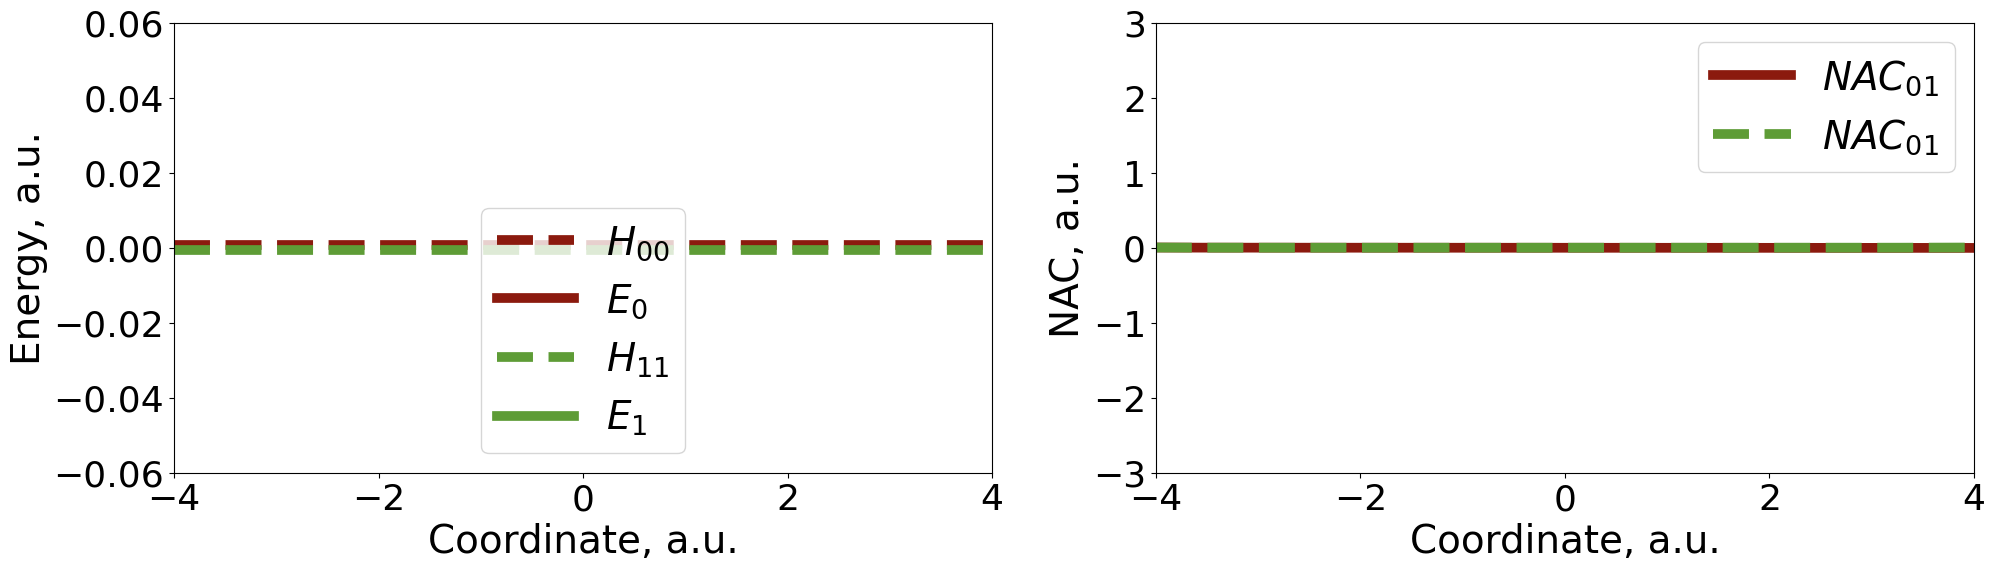

In [6]:
list_states = [x for x in range(model_params["nstates"])]

# Holstein
#plot_params.update( { "xlim":[-5, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 5.0, 0.05, plot_params)

# Tully
#plot_params.update( { "xlim":[-15.0, 15.0], "ylim":[-0.4, 0.4], "ylim2":[-0.4, 0.4], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -15.0, 15.0, 0.05, plot_params)

# Esch-Levine
plot_params.update( { "xlim":[-4, 4], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 8.0, 0.05, plot_params)

## 4. Choosing the Nonadiabatic Dynamics Methodology 
<a name="4"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates:2` - all our models are 2-level systems
* `dt:1` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `frogress_frequency:0.1` - printing out a message evry `2500 x 0.1 = 250` steps
* `which_adi_states` - properties of which adiabatic states to save, we only have 2
* `which_dia_states` - properties of which diabatic states to save, we only have 2
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [7]:
# For setting nsteps
list_nsteps = []
for i in range(len(all_model_params)):
    if all_model_params[i]["model"] == 1: #Holstein
        list_nsteps.append(8000)
    elif all_model_params[i]["model"] == 2: #ECR
        list_nsteps.append(4000)
    elif all_model_params[i]["model"] == 3: #DAG
        list_nsteps.append(3000)
    elif all_model_params[i]["model"] == 4: #Esch-Levine
        list_nsteps.append(25000)

In [8]:
NSTATES = model_params["nstates"]

dyn_general = { "nsteps":list_nsteps[model_indx], "ntraj":50, "nstates":NSTATES,
                "dt":1.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

#[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
#                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi" ]

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices. For methods based on surface hopping, default options are used for frustrated hops and how to rescale momenta on hops.

In [9]:
#################################
# Give the recipe above an index
method_indx = 7
#################################

if method_indx == 0:
    ehrenfest_dia.load(dyn_general)  # Ehrenfest, dia
elif method_indx == 1:
    ehrenfest_adi_ld.load(dyn_general)  # Ehrenfest, adi with LD
elif method_indx == 2:
    mfsd.load(dyn_general)  # MFSD
    
elif method_indx == 3:
    fssh.load(dyn_general)  # FSSH
elif method_indx == 4:
    sdm.load(dyn_general)  # SDM with default EDC parameters
elif method_indx == 5:
    bcsh.load(dyn_general)  # BCSH 

elif method_indx == 6:
    shxf.load(dyn_general)  # SHXF
elif method_indx == 7:
    mqcxf.load(dyn_general)  # MQCXF
elif method_indx == 8:
    ehxf.load(dyn_general)  # EhXF 

## 5. Choosing initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [10]:
#*********************** This is for the initial condition type **************************
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are sampled

nucl_params = { "ndof":1, "q":[-4.0], "p":[0.0], 
                "mass":[2000.0], "force_constant":[0.01], 
                "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

istates = []
for i in range(NSTATES):
    istates.append(0.0)    
    
elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":NSTATES, "nadi":NSTATES, 
               "rep":rep, "init_type":icond_elec, "istates":istates
              }

#******************** This is for specific values in initial conditions *******************
#####################################
# Select a specific initial condition
icond_indx = 0
#####################################    

if model_indx in [0, 1]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-1.0]
        elec_params["istates"][1] = 1.0 
elif model_indx in [2]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-2.0]
        elec_params["istates"][1] = 1.0 
elif model_indx in [3]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][0] = 1.0
    elif icond_indx==1:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0
elif model_indx in [4]: # Tully, ECR
    if icond_indx==0:
        nucl_params["q"] = [-15.0]
        nucl_params["p"] = [25.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [5]: # Tully, DAG
    if icond_indx==0:
        nucl_params["q"] = [-20.0]
        nucl_params["p"] = [20.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [6]: # Esch-Levine 2-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0
elif model_indx in [7]: # Esch-Levine 3-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][2] = 1.0
elif model_indx in [8,9]: # Esch-Levine 5-level, two types
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][4] = 1.0

## 6. Running the calculations
<a name="6"></a>[Back to TOC](#TOC)

In [11]:
%%time

dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model5-method7-icond0
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
se

 step= 300
 step= 600
 step= 900
 step= 1200
 step= 1500
 step= 1800
 step= 2100
 step= 2400
 step= 2700
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'q', 'p', 'f', 'Cadi', 'Cdia'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named q/data
Saving the dataset named p/data
Saving the dataset named f/data
Saving the dataset named Cadi/data
Saving the dataset named Cdia/data
Saving the dataset named Epot_ave/data
Saving the dataset named Ekin_ave/data
Saving the dataset named Etot_ave/data
Saving the dataset named se_pop_adi/data
Saving the dataset named se_pop_dia/da

## 7. Plotting the results
<a name="7"></a>[Back to TOC](#TOC)

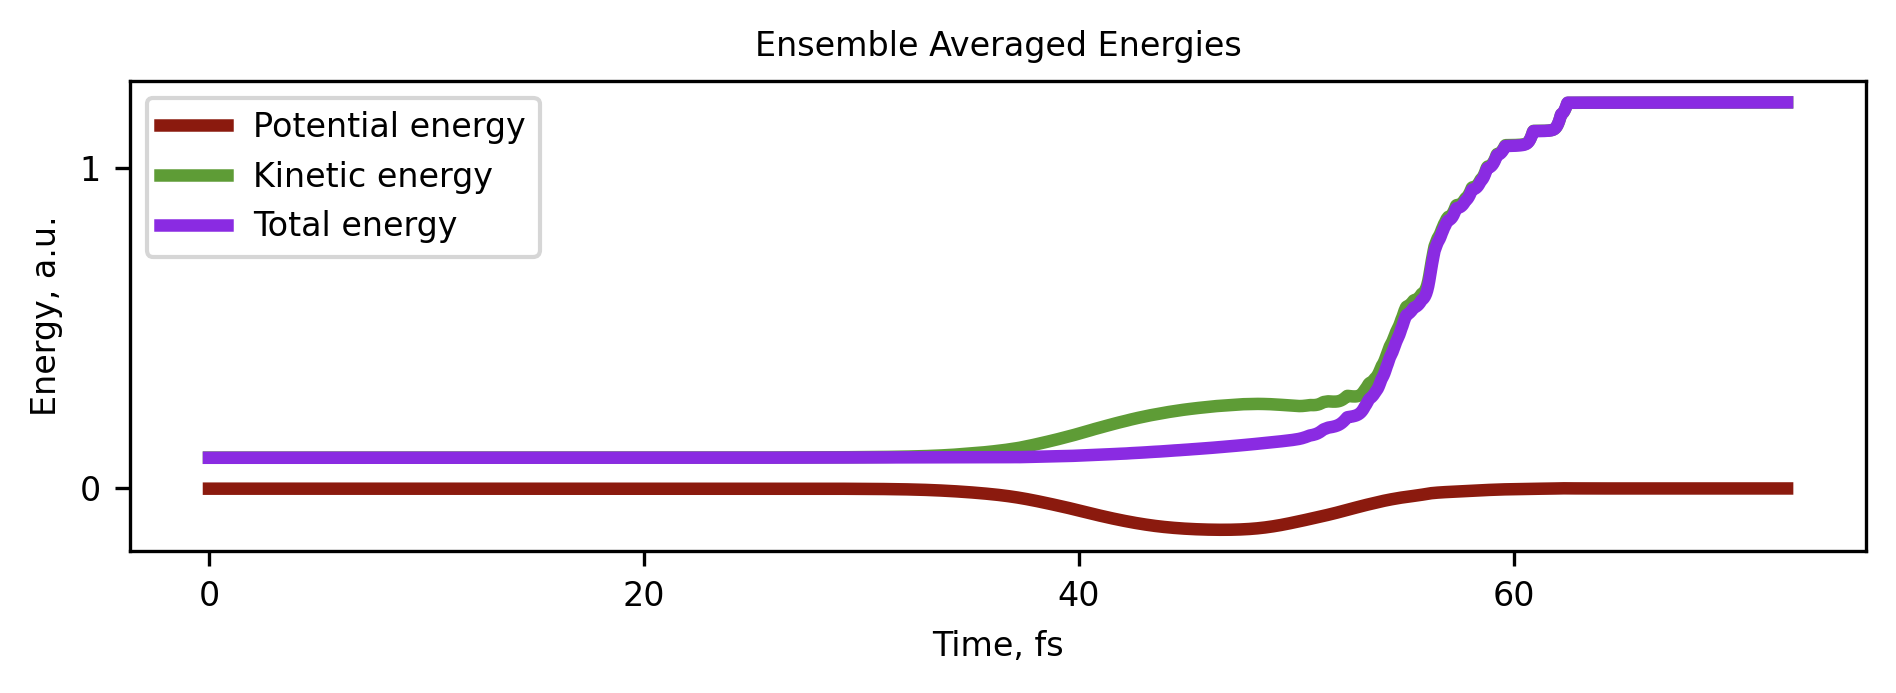

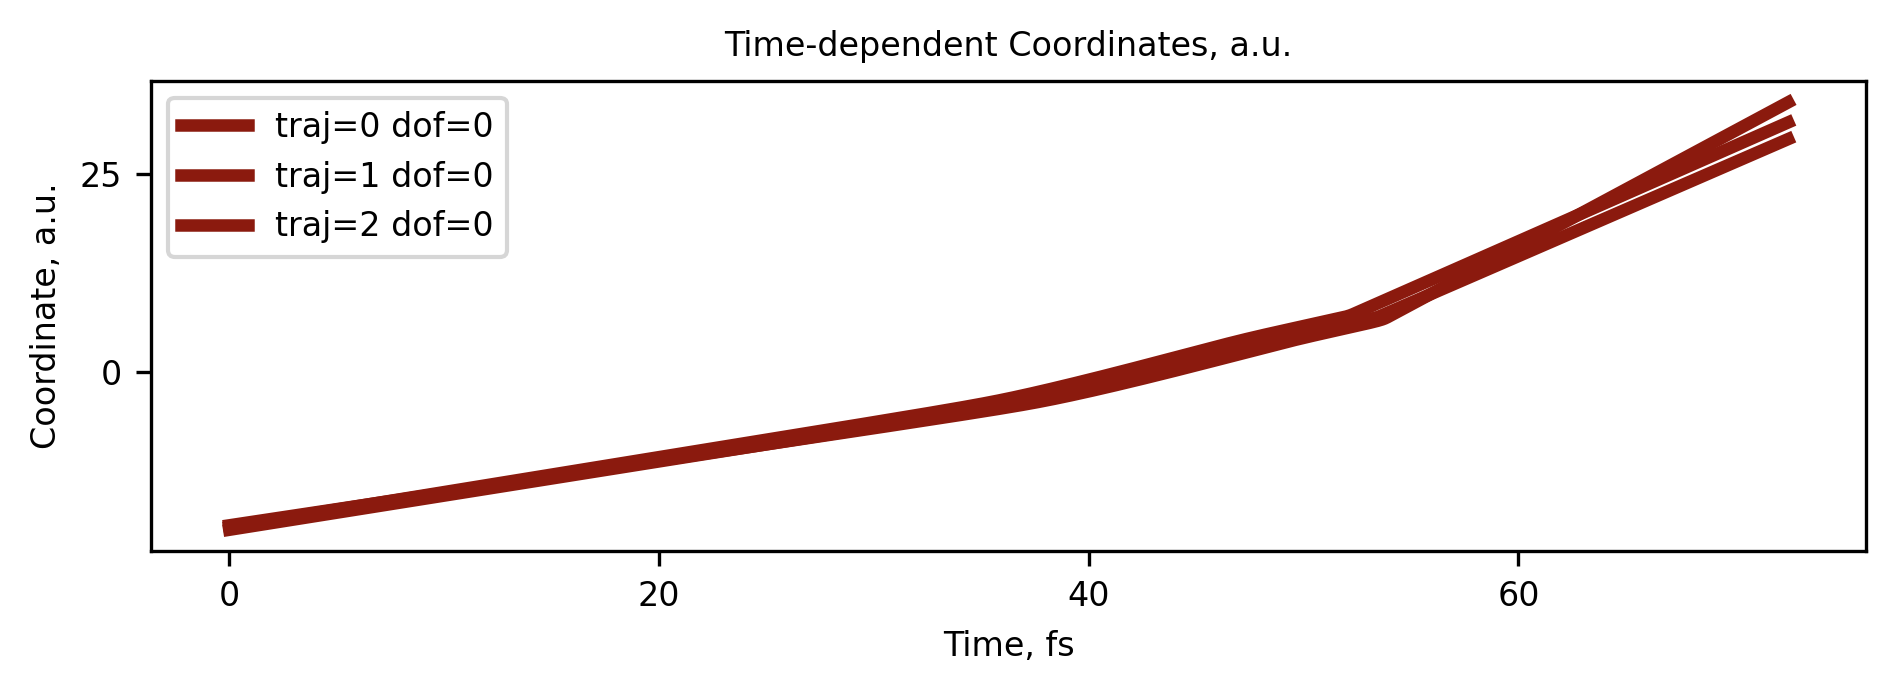

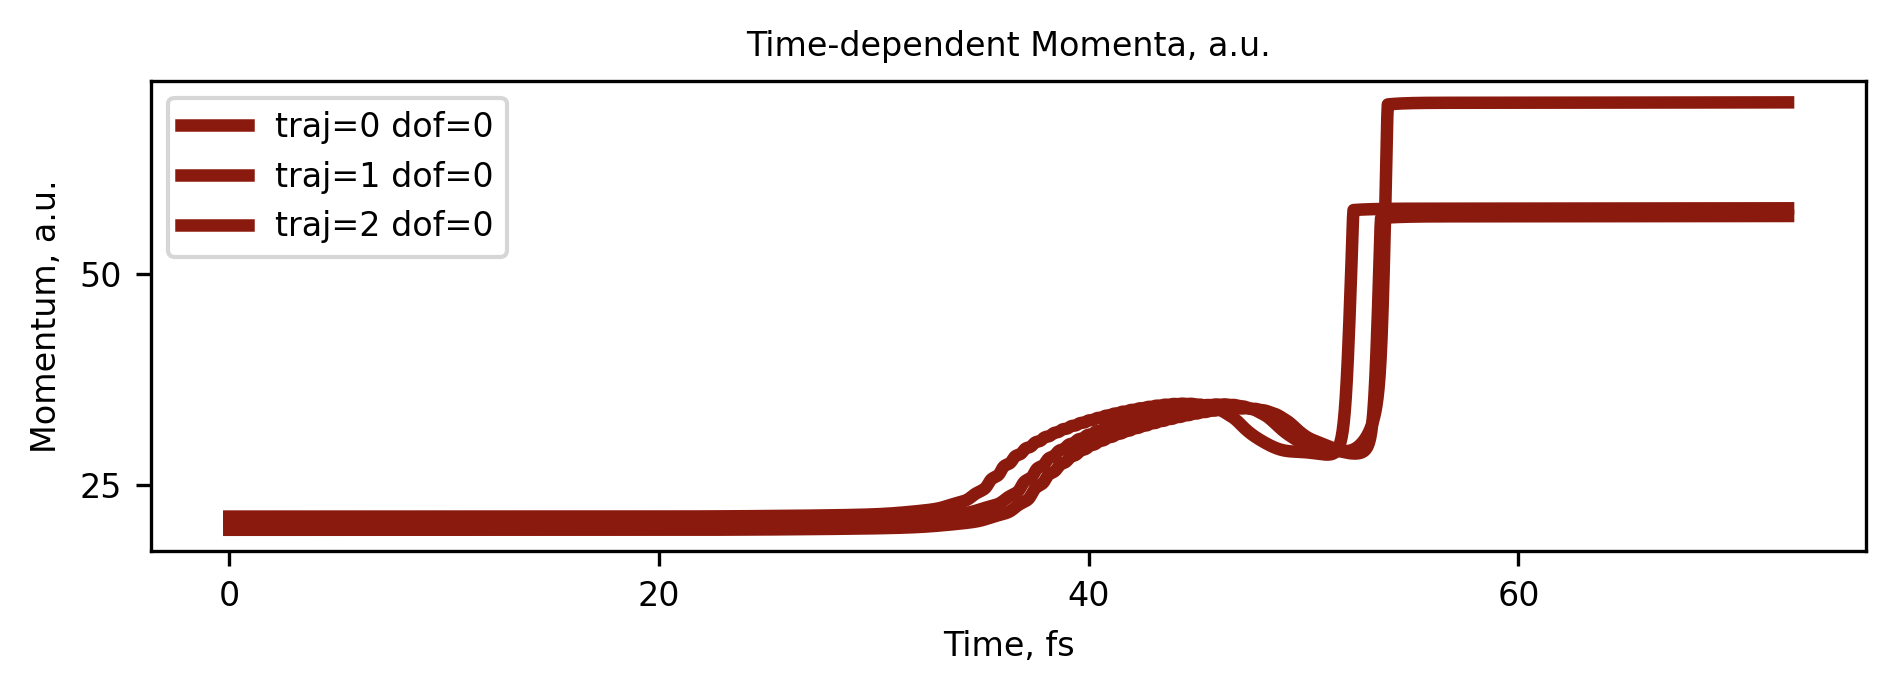

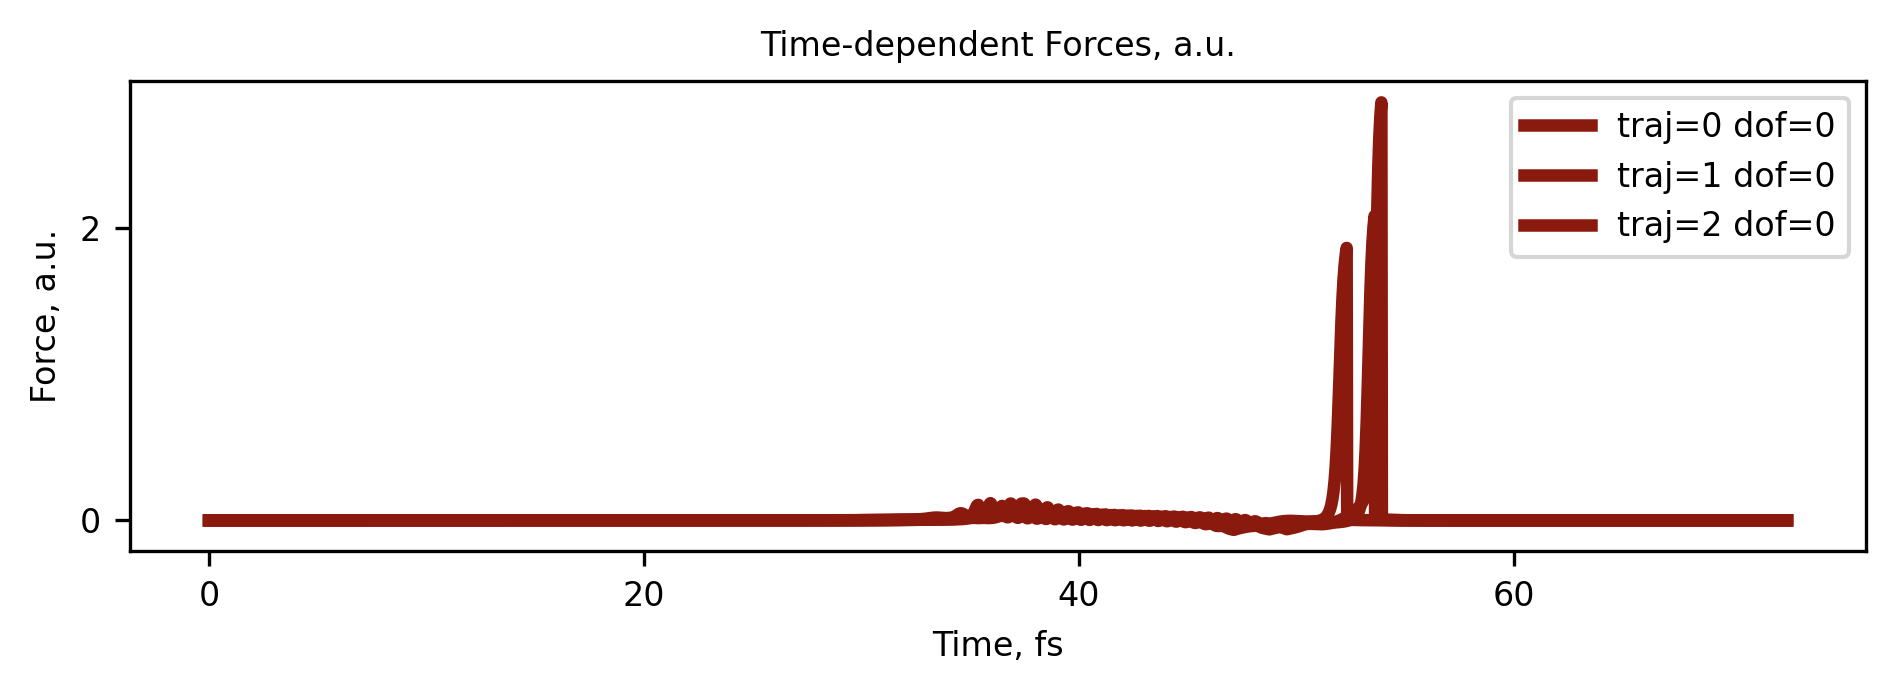

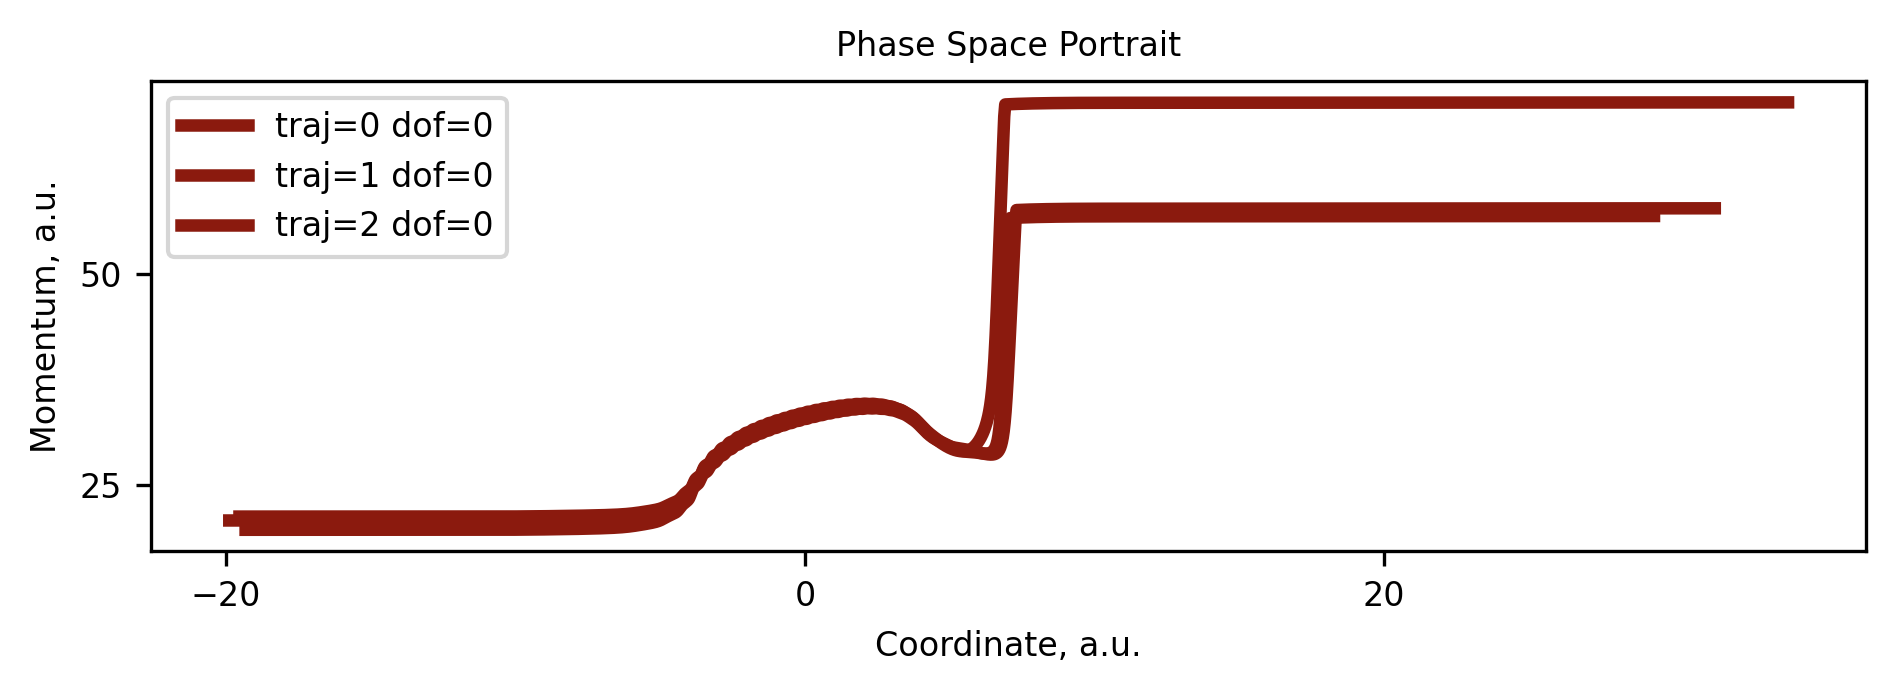

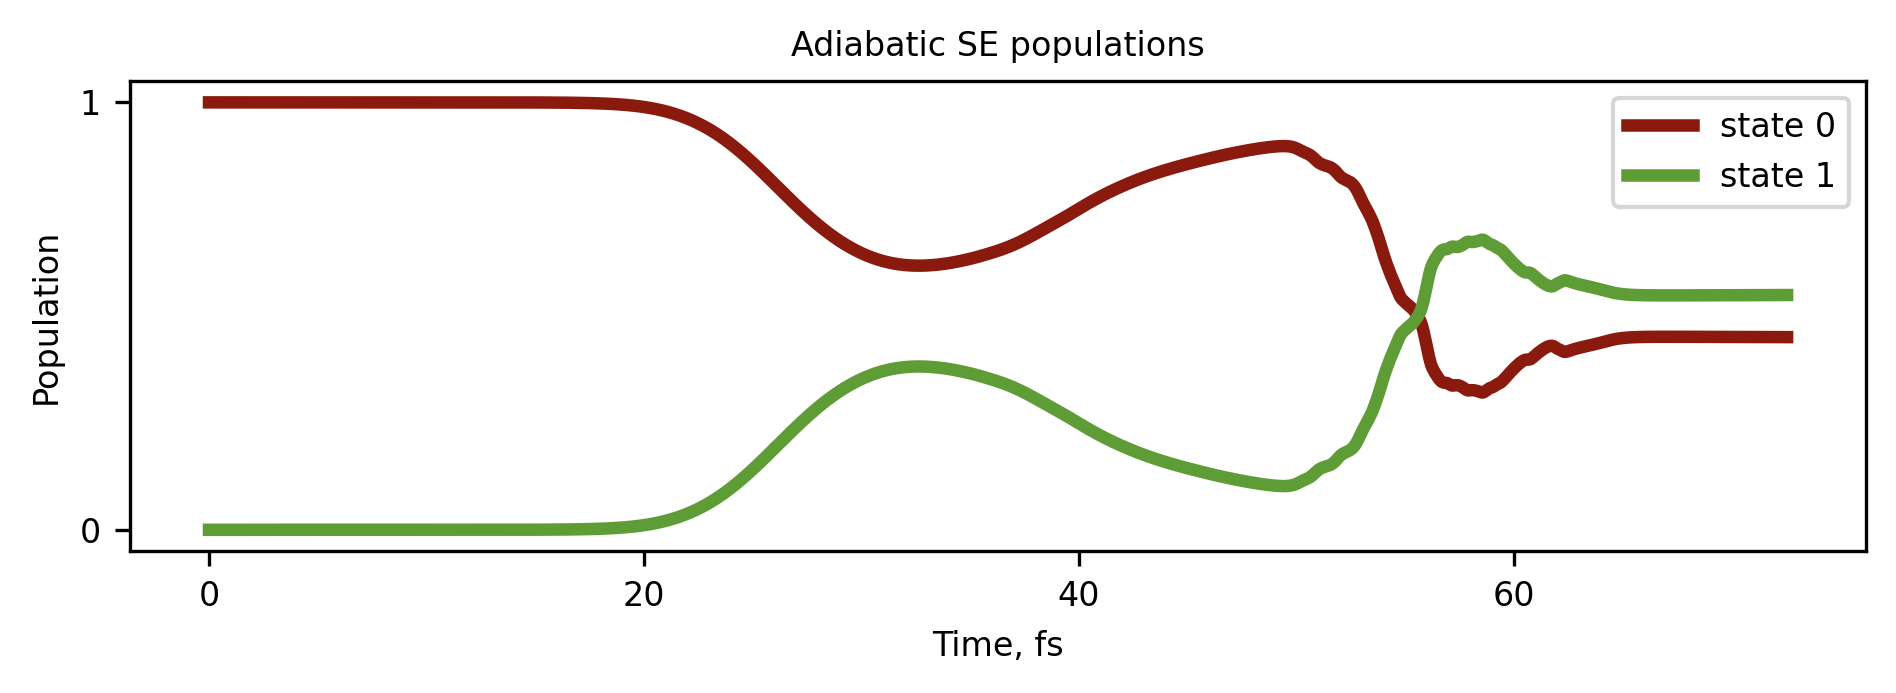

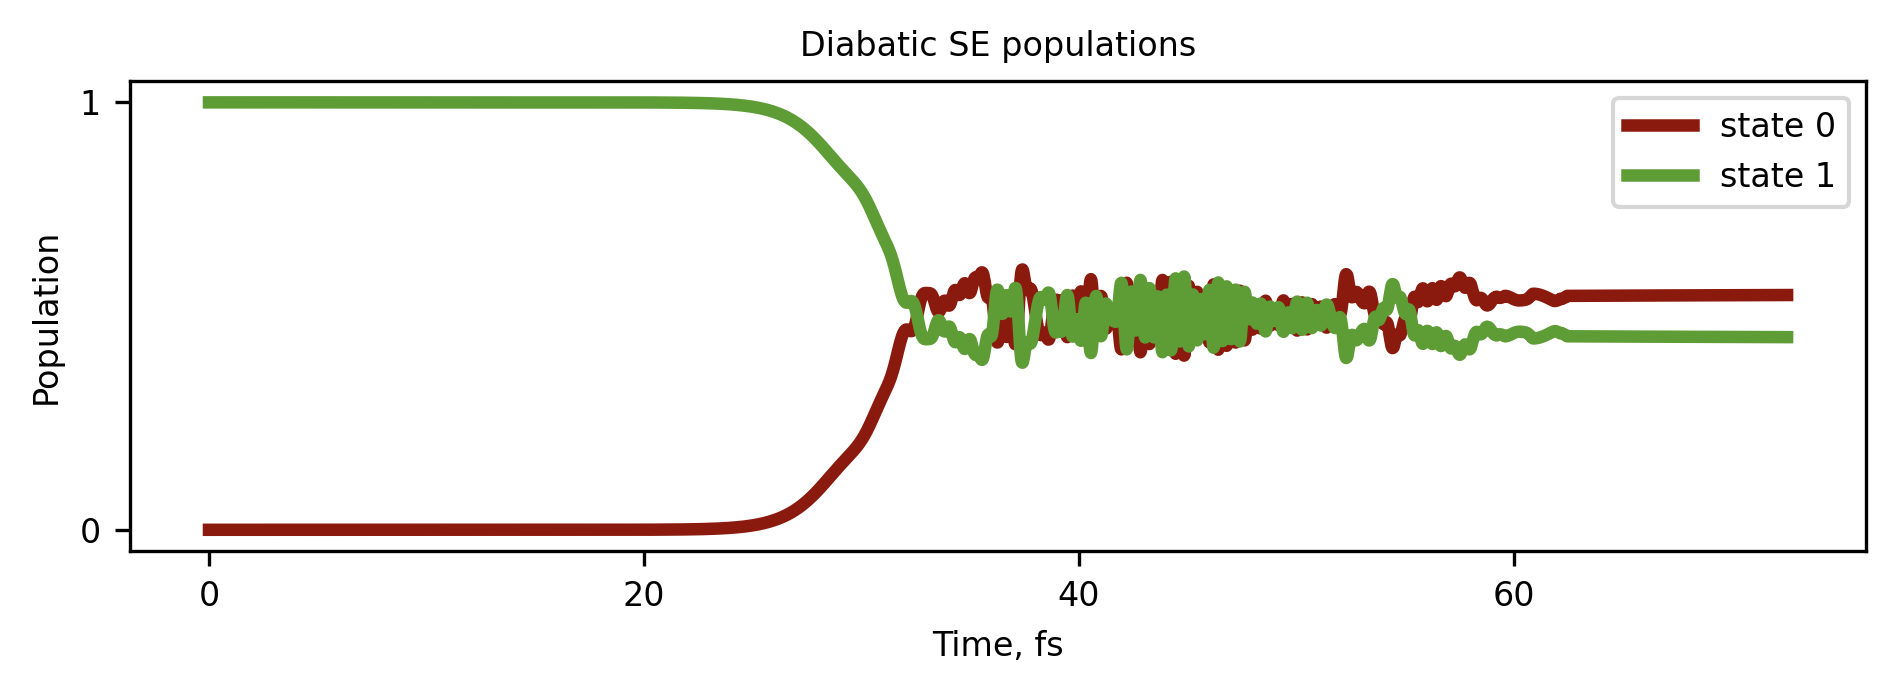

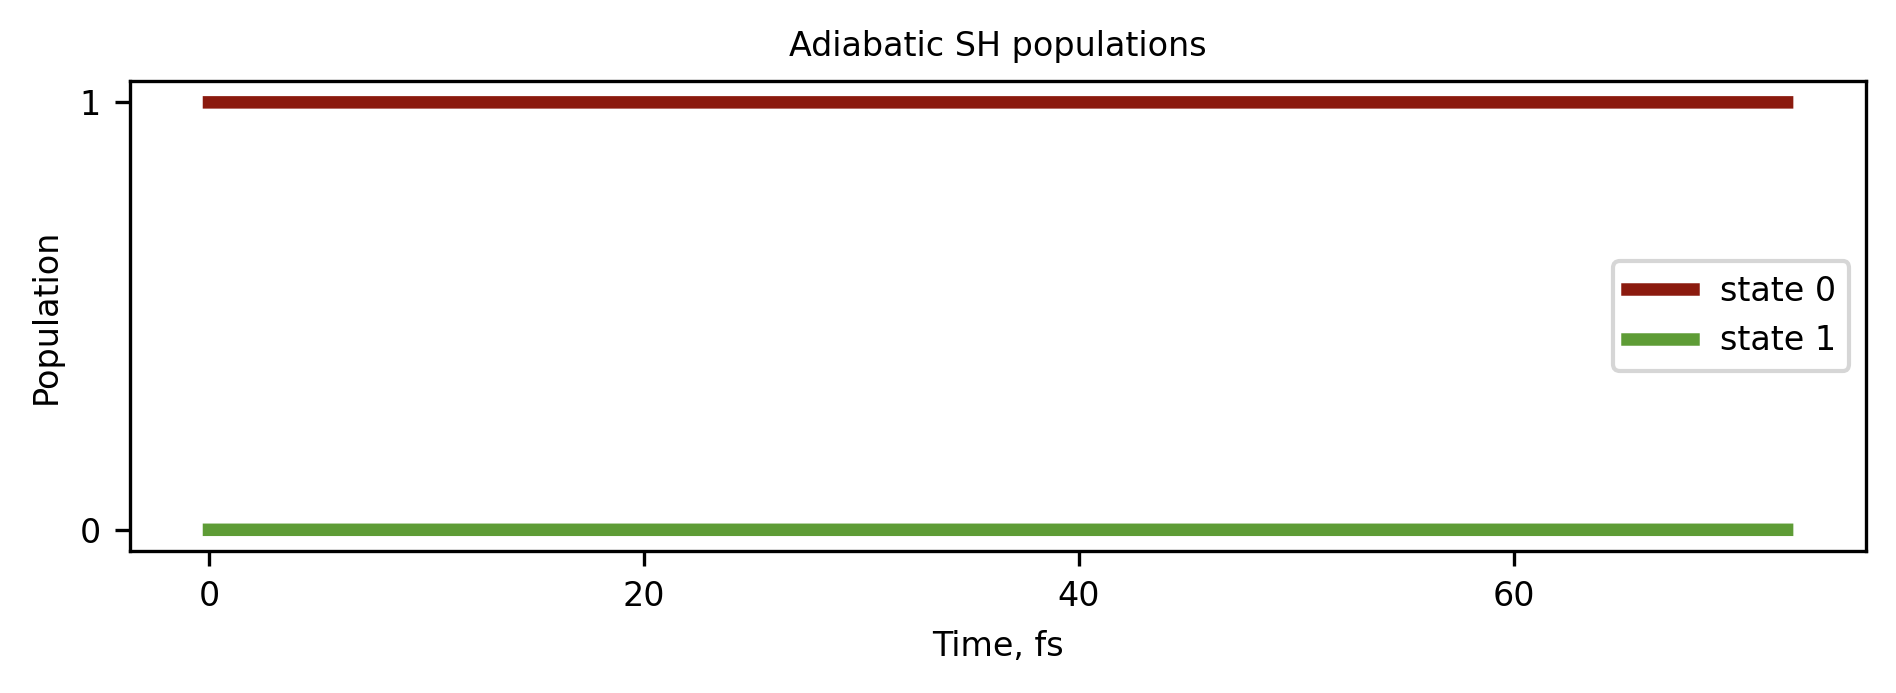

In [12]:
#============ Plotting ==================
pref = F"model{model_indx}-method{method_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1, 2], "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

#"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
#                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
#                                "time_overlaps", "basis_transform"
#                               ], 

tsh_dynamics_plot.plot_dynamics(plot_params)

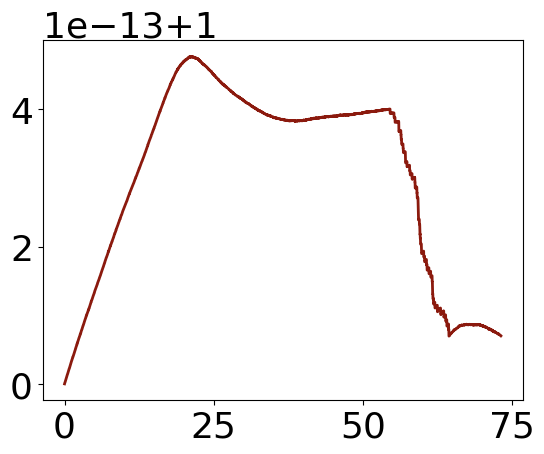

In [13]:
with h5py.File(F"model{model_indx}-method{method_indx}-icond{icond_indx}/mem_data.hdf", 'r') as f:
    #plt.title("Monitoring the norm")
    plt.plot(f["time/data"][:]/41.0, f["se_pop_adi/data"][:, 0]+f["se_pop_adi/data"][:, 1], label="norm",
linewidth=2, color = colors["11"])
    plt.savefig(pref + "/norm.png")

## 8. Comparison with quantum dynamics
<a name="8"></a>[Back to TOC](#TOC)

In [25]:
# For setting the initial state
state_indx = [i for i in range(len(elec_params["istates"])) if elec_params["istates"][i] > 0.5][0]


def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

In [26]:
exact_params = { "nsteps":list_nsteps[model_indx], "dt":1.0, "progress_frequency":1.0/2500,
                 "rmin":[-25.0], "rmax":[25.0], "dx":[0.025], "nstates":model_params["nstates"],
                  "x0":nucl_params["q"], "p0":nucl_params["p"], "istate":[1,state_indx], "masses":[2000.0], "k":[0.01],
                  "integrator":"SOFT",
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":2, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":F"exact-model{model_indx}-icond{icond_indx}", "prefix2":F"exact-model{model_indx}-icond{icond_indx}",
                  "use_compression":0, "compression_level":[0, 0, 0]
               }

wfc = dvr.init_wfc(exact_params, potential, model_params)
savers = dvr_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
dvr.run_dynamics(wfc, exact_params, model_params, savers)

Grids are initialized
Added a Gaussian to the grid
Dimension 0 has 2048 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -20
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 2048 grid points
Norm (dia) =  0.9999999999999997
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.0005590427612848693
Ekin (adi) =  0.0005590169943749458
Epot (dia) =  0.01609319229576519
Epot (adi) =  0.01609319229576519
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 3
 step= 6
 step= 9
 step= 12
 step= 15
 step= 18
 step= 21
 step= 24
 step= 27
 step= 30
 step= 33
 step= 36
 step= 39
 step= 42
 step= 45
 step= 48
 step= 51
 step= 54
 step= 57
 step= 60
 step= 63
 step= 66
 step= 69
 step= 72
 step= 75
 step= 78
 step= 81
 step= 84
 step= 87
 step= 90
 step= 93


 step= 1239
 step= 1242
 step= 1245
 step= 1248
 step= 1251
 step= 1254
 step= 1257
 step= 1260
 step= 1263
 step= 1266
 step= 1269
 step= 1272
 step= 1275
 step= 1278
 step= 1281
 step= 1284
 step= 1287
 step= 1290
 step= 1293
 step= 1296
 step= 1299
 step= 1302
 step= 1305
 step= 1308
 step= 1311
 step= 1314
 step= 1317
 step= 1320
 step= 1323
 step= 1326
 step= 1329
 step= 1332
 step= 1335
 step= 1338
 step= 1341
 step= 1344
 step= 1347
 step= 1350
 step= 1353
 step= 1356
 step= 1359
 step= 1362
 step= 1365
 step= 1368
 step= 1371
 step= 1374
 step= 1377
 step= 1380
 step= 1383
 step= 1386
 step= 1389
 step= 1392
 step= 1395
 step= 1398
 step= 1401
 step= 1404
 step= 1407
 step= 1410
 step= 1413
 step= 1416
 step= 1419
 step= 1422
 step= 1425
 step= 1428
 step= 1431
 step= 1434
 step= 1437
 step= 1440
 step= 1443
 step= 1446
 step= 1449
 step= 1452
 step= 1455
 step= 1458
 step= 1461
 step= 1464
 step= 1467
 step= 1470
 step= 1473
 step= 1476
 step= 1479
 step= 1482
 step= 1485
 ste

 step= 3291
 step= 3294
 step= 3297
 step= 3300
 step= 3303
 step= 3306
 step= 3309
 step= 3312
 step= 3315
 step= 3318
 step= 3321
 step= 3324
 step= 3327
 step= 3330
 step= 3333
 step= 3336
 step= 3339
 step= 3342
 step= 3345
 step= 3348
 step= 3351
 step= 3354
 step= 3357
 step= 3360
 step= 3363
 step= 3366
 step= 3369
 step= 3372
 step= 3375
 step= 3378
 step= 3381
 step= 3384
 step= 3387
 step= 3390
 step= 3393
 step= 3396
 step= 3399
 step= 3402
 step= 3405
 step= 3408
 step= 3411
 step= 3414
 step= 3417
 step= 3420
 step= 3423
 step= 3426
 step= 3429
 step= 3432
 step= 3435
 step= 3438
 step= 3441
 step= 3444
 step= 3447
 step= 3450
 step= 3453
 step= 3456
 step= 3459
 step= 3462
 step= 3465
 step= 3468
 step= 3471
 step= 3474
 step= 3477
 step= 3480
 step= 3483
 step= 3486
 step= 3489
 step= 3492
 step= 3495
 step= 3498
 step= 3501
 step= 3504
 step= 3507
 step= 3510
 step= 3513
 step= 3516
 step= 3519
 step= 3522
 step= 3525
 step= 3528
 step= 3531
 step= 3534
 step= 3537
 ste

 step= 5343
 step= 5346
 step= 5349
 step= 5352
 step= 5355
 step= 5358
 step= 5361
 step= 5364
 step= 5367
 step= 5370
 step= 5373
 step= 5376
 step= 5379
 step= 5382
 step= 5385
 step= 5388
 step= 5391
 step= 5394
 step= 5397
 step= 5400
 step= 5403
 step= 5406
 step= 5409
 step= 5412
 step= 5415
 step= 5418
 step= 5421
 step= 5424
 step= 5427
 step= 5430
 step= 5433
 step= 5436
 step= 5439
 step= 5442
 step= 5445
 step= 5448
 step= 5451
 step= 5454
 step= 5457
 step= 5460
 step= 5463
 step= 5466
 step= 5469
 step= 5472
 step= 5475
 step= 5478
 step= 5481
 step= 5484
 step= 5487
 step= 5490
 step= 5493
 step= 5496
 step= 5499
 step= 5502
 step= 5505
 step= 5508
 step= 5511
 step= 5514
 step= 5517
 step= 5520
 step= 5523
 step= 5526
 step= 5529
 step= 5532
 step= 5535
 step= 5538
 step= 5541
 step= 5544
 step= 5547
 step= 5550
 step= 5553
 step= 5556
 step= 5559
 step= 5562
 step= 5565
 step= 5568
 step= 5571
 step= 5574
 step= 5577
 step= 5580
 step= 5583
 step= 5586
 step= 5589
 ste

 step= 7395
 step= 7398
 step= 7401
 step= 7404
 step= 7407
 step= 7410
 step= 7413
 step= 7416
 step= 7419
 step= 7422
 step= 7425
 step= 7428
 step= 7431
 step= 7434
 step= 7437
 step= 7440
 step= 7443
 step= 7446
 step= 7449
 step= 7452
 step= 7455
 step= 7458
 step= 7461
 step= 7464
 step= 7467
 step= 7470
 step= 7473
 step= 7476
 step= 7479
 step= 7482
 step= 7485
 step= 7488
 step= 7491
 step= 7494
 step= 7497
 step= 7500
 step= 7503
 step= 7506
 step= 7509
 step= 7512
 step= 7515
 step= 7518
 step= 7521
 step= 7524
 step= 7527
 step= 7530
 step= 7533
 step= 7536
 step= 7539
 step= 7542
 step= 7545
 step= 7548
 step= 7551
 step= 7554
 step= 7557
 step= 7560
 step= 7563
 step= 7566
 step= 7569
 step= 7572
 step= 7575
 step= 7578
 step= 7581
 step= 7584
 step= 7587
 step= 7590
 step= 7593
 step= 7596
 step= 7599
 step= 7602
 step= 7605
 step= 7608
 step= 7611
 step= 7614
 step= 7617
 step= 7620
 step= 7623
 step= 7626
 step= 7629
 step= 7632
 step= 7635
 step= 7638
 step= 7641
 ste

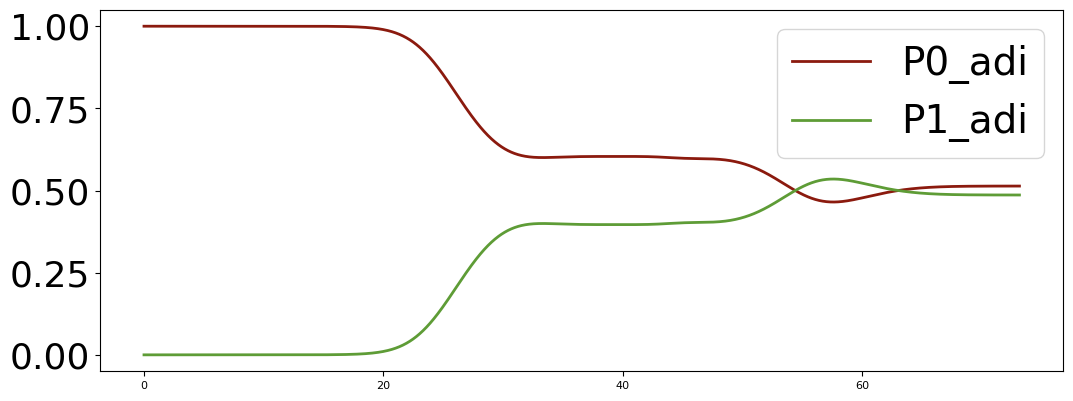

In [13]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=8)
with h5py.File(F"exact-model{model_indx}-icond{icond_indx}/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])
    #plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 2, 0], label="P2_adi", linewidth=2, color = colors["31"])
    #plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 3, 0], label="P3_adi", linewidth=2, color = colors["41"])
    #plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 4, 0], label="P4_adi", linewidth=2, color = colors["32"])
    plt.legend()